# Transitions Notebook 

In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os
%load_ext memory_profiler
import cProfile

In [2]:
import matplotlib as mpl
mpl.rcParams["svg.fonttype"] = "none"

# Utils Functions

In [3]:
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale("log")

In [4]:
def transition(states, template, epsilon=0):
    """
    author: BK
    states : dict of nts.Interval_set
    template : list of state.
    epsilon : int, will drop any 
     in which there is an epoch shorter than epsilon 's'
    This function will find transition that match the template 
    """
    if epsilon is list:
        print("eplist")
    long = pd.DataFrame()
    for s, i in states.items():
        i["state"] = s
        long = pd.concat((i, long))
        del i["state"]
    order = np.argsort(long.start)
    long = long.iloc[order]

    transition_times = []
    transition_intervals = []
    for i, s in enumerate(long.state):
        tmp = list(long.state[i : i + len(template)])
        if tmp == template:
            tmp_transition = long.iloc[i : i + len(template)]
            #             print(d.iloc[i:i+len(template)])
            length = (tmp_transition.end - tmp_transition.start) / 1_000_000
            if np.any(length.values < epsilon):
                continue
            tmp_pre = np.array(tmp_transition.end[:-1])
            tmp_post = np.array(tmp_transition.start[1:])
            tmp_times = np.mean([tmp_pre, tmp_post], 0)

            transition_intervals.append(
                [tmp_transition.start.iloc[0], tmp_transition.end.iloc[-1]]
            )
            transition_times.append(tmp_times)

    transition_times = np.array(transition_times)
    transition_intervals = np.array(transition_intervals)
    transition_intervals = nts.IntervalSet(
        start=transition_intervals[:, 0],
        end=transition_intervals[:, 1],
        force_no_fix=True,
    )
    return transition_intervals, transition_times

# Computing Activity At Transitions

In [5]:
def compute_transition_activity(neurons, intervals, timing, bin_epochs, n_event):

    transition_activity = []
    for event, t in zip(intervals.iloc, timing):  # For each transitions
        if n_event == 2:
            epochs = np.array([(event.start, t[0]), (t[0], event.end)], dtype=np.int64)
        if n_event == 3:
            epochs = np.array([[event.start, t[0]], [t[0], t[1]], [t[1], event.end]])
        epochs = nts.IntervalSet(start=epochs[:, 0], end=epochs[:, 1])
        # Creates intervals for each state of the transitions events.

        #         binned = np.array(shape = (252,np.sum(bin_epochs)))
        #         binned = np.empty(shape = (252,np.sum(bin_epochs),len(intervals)+1))
        binned = np.empty(shape=(len(neurons), 1))
        for i, epoch in enumerate(epochs.as_units("s").iloc):
            start = epoch.start
            end = epoch.end
            nbins = bin_epochs[i]
            _, b = bk.compute.binSpikes(neurons, start=start, stop=end, nbins=nbins)
            b = b / ((end - start) / nbins)  # Converting to firing rates
            binned = np.hstack((binned, b))
        binned = binned[:, 1:]
        transition_activity.append(binned)

    transition_activity = np.array(transition_activity)
    transition_activity = np.moveaxis(transition_activity, 0, 2)

    return transition_activity


def main(local_path="Rat08/Rat08-20130713", arg=None, plot=False, save=False):
    # Variables :
    if arg == None:
        transition_interest = [
            ["Rem", "sws", "Rem"]
        ]  # Template of transitions to follow.
        bin_epochs = [12, 30, 12]
        n_event = 3
    else:
        transition_interest = [arg[0]]
        bin_epochs = arg[1]
        n_event = arg[2]


    bk.load.current_session_linux(base_folder = '/media/billel/GGLab-01-BK/DATA/GG-Dataset/',local_path=local_path)
    neurons, metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()

    for i, transition_name in enumerate(
        transition_interest
    ):  # For each kind of transitions
        print(f"Computing {transition_name} transitions")
        intervals, timing = transition(
            states, transition_name, epsilon=50
        )  # Find the timing of the transitions
        print(f"Found {len(intervals)} transitions")

        transition_activity = compute_transition_activity(
            neurons, intervals, timing, bin_epochs, n_event
        )

        if plot:
            print(np.mean(transition_activity[metadata.Region == "BLA"], 2).T.shape)
            y_bla = scipy.stats.zscore(
                np.mean(transition_activity[metadata.Region == "BLA"], 2).T, 0
            )
            y_hpc = scipy.stats.zscore(
                np.mean(transition_activity[metadata.Region == "Hpc"], 2).T, 0
            )

            plt.figure()
            plt.plot(y_bla, "green")
            plt.plot(y_hpc, "blue")

            plt.title(f"Rat:{bk.load.rat}, Day{bk.load.day} {bk.load.session}")
        print(os.getcwd())
        # sanity_check(neurons,states,intervals,timing)


        return np.array(transition_activity), metadata, bin_epochs

def NREM_Control(local_path="Rat08/Rat08-20130713", args=None, plot=False, save=False):

    NREM_length = 250
    REM_length = 80 * 1_000_000
    bin_epochs = [30, 12, 30]
    n_events = len(bin_epochs)

    bk.load.current_session_linux(base_folder = "/media/billel/GGLab-01-BK/DATA/GG-Dataset", local_path=local_path)
    neurons, metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()

    intervals, _ = transition(states, ["sws"], NREM_length)
    m = (intervals.start + intervals.end) / 2
    timing = np.array([m - (REM_length / 2), m + (REM_length / 2)]).T
    print(f"Found {len(intervals)} transitions")

    transition_activity = compute_transition_activity(
        neurons, intervals, timing, bin_epochs,n_events
    )
    
    # # sanity_check(neurons,states,intervals,timing)

    return np.array(transition_activity), metadata, bin_epochs

# Merging After Batch

In [6]:
def merge(batch,name,discard):
    transitions_activity = []
    metadata = []
    n_transitions = 0
    n_sessions = 0
    for i,b in batch.items():
        if i not in discard:
#          if True:
            transitions_activity.append(np.mean(b[0],2))
            metadata.append(b[1])
            n_transitions += b[0].shape[2]
            n_sessions += 1 
            bins_epochs = b[2]

    s = np.append(0,np.cumsum(bins_epochs))[:-1]
    e = np.cumsum(bins_epochs)-1
    
    intervals = np.array([s,e]).T
    merged = {'name':name,
              'average_transition':np.vstack(transitions_activity),
              'metadata':pd.concat(metadata),
              'n_transitions':n_transitions,
              'n_sessions':n_sessions,
              'intervals':intervals}
              
    merged['metadata'].Type[merged['metadata'].Region == 'CeCM'] = 'Int'
    return merged

In [7]:
discard = [
    "Rat08-20130718",
    "Rat09-20140408",
    "Rat09-20140409",
    "Rat10-20140619",
    "Rat10-20140620",
    "Rat10-20140622",
]

# Plot double transitons and pre vs post

In [68]:
def plot_average_transitions(merged_activity,norm = 'zscore',ax = None,style = 'b-'):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if norm == 'zscore':
        merged_activity = zscore(merged_activity,1)
    ax.plot(np.nanmean(merged_activity,0),style)

def plot_violin_pre_post(merged_activity,pre,post,title,norm = 'zscore', ax = None,ylim = None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if norm == 'zscore':
        merged_activity = zscore(merged_activity,1)

        
    ### Parse data in df : 
    
    activity = {'pre':np.nanmean(merged_activity[:,pre[0]:pre[1]],1),
                'post':np.nanmean(merged_activity[:,post[0]:post[1]],1)}

    if norm != 'zscore':
        not_zeros = (activity['pre'] !=0) & (activity['post'] !=0)
        activity['pre'] = np.log10(activity['pre'][not_zeros])
        activity['post'] = np.log10(activity['post'][not_zeros])
        ax.set_ylabel('Log(FR) ')

    a = np.array([activity['pre'], activity['post']]).T
    df = pd.DataFrame(a, columns=['Pre', 'Post'])
    plt.sca(ax)
    sns.violinplot(data = df)
    if ylim is not None:
        ax.set_ylim(ylim)
    plt.title(title)

def make_figure(merged,stru,norm = 'zscore',ylimL = None,ylimR = None,ylim_violin = None,**kwargs):
    
    name = merged['name']
    average_transition = merged['average_transition']
    intervals = merged['intervals']
    metadata = merged['metadata']

    if 'intervals_colors' in kwargs:
        intervals_colors = kwargs['intervals_colors']
    else:
        intervals_colors = ['grey'] * len(intervals)

    fig, ax = plt.subplot_mosaic("""
                                  AB
                                  AC
                                 """,
                                dpi = 180)
    stru_pyr_average = average_transition[(metadata['Region'] == stru) 
                                                    & (metadata['Type'] == 'Pyr')]
    stru_int_average = average_transition[(metadata['Region'] == stru) 
                                                    & (metadata['Type'] == 'Int')]
    if norm == 'zscore': 
        plot_average_transitions(stru_pyr_average,norm,ax = ax['A'],style = '-b')
        plot_average_transitions(stru_int_average,norm,ax = ax['A'],style = '-k')
        ax['A'].set_ylabel('Firing Rates (zscore)')
        ax['A'].set_xlabel('Normalized Time')
    else:
        plot_average_transitions(stru_pyr_average,norm,ax = ax['A'],style = '-b')
        right = ax['A'].twinx()
        plot_average_transitions(stru_int_average,norm,ax = right,style = '-k')
        ax['A'].set_ylabel('Firing Rates (Hz)')
        ax['A'].set_xlabel('Normalized Time')

    if ylimL is not None: ax['A'].set_ylim(ylimL[0],ylimL[1])
    if ylimR is not None: right.set_ylim(ylimR[0],ylimR[1])

    
    for n,(s,e) in enumerate(intervals):
        ax['A'].axvspan(s,e,color = intervals_colors[n])


    pre = [intervals[0,0], intervals[0,1]]
    post = [intervals[-1,0], intervals[-1,1]]
    plot_violin_pre_post(stru_pyr_average,pre,post,'Pyr',norm,ax = ax['B'],ylim = ylim_violin)
    plot_violin_pre_post(stru_int_average,pre,post,'Int',norm,ax = ax['C'],ylim = ylim_violin)

    ax['A'].set_title((f'{name}'))
    plt.suptitle(stru)
    plt.tight_layout()
    return 0


# Make Statistics

In [69]:
def statistics(merged,stru,pre,post):
    stru_pyr_average = merged['average_transition'][(merged['metadata']['Region'] == stru) 
                                                    & (merged['metadata']['Type'] == 'Pyr')]
    stru_int_average = merged['average_transition'][(merged['metadata']['Region'] == stru) 
                                                    & (merged['metadata']['Type'] == 'Int')]
    activity = {'pre':np.nanmean(stru_pyr_average[:,pre[0]:pre[1]],1),
            'post':np.nanmean(stru_pyr_average[:,post[0]:post[1]],1)}

    _, p_pyr = scipy.stats.wilcoxon(activity['pre'], activity['post'])
    
    activity = {'pre':np.nanmean(stru_int_average[:,pre[0]:pre[1]],1), 
                'post':np.nanmean(stru_int_average[:,post[0]:post[1]],1)}

    _, p_int = scipy.stats.wilcoxon(activity['pre'], activity['post'])

    return p_pyr, p_int


# REM_NREM

In [10]:
arg = [["Rem", "sws"], [12, 30], 2]
REM_NREM = bk.load.batch(main, arg, verbose=False, linux=True)
m_REM_NREM = merge(REM_NREM,'REM_NREM',discard)
# make_figure(m_REM_NREM,'BLA',norm = 'no',intervals_colors = ['orange','grey'],ylimL=yLimPyr,ylimR=yLimInt)

100%|██████████| 61/61 [00:17<00:00,  3.49it/s]

Batch finished in 17.481842756271362
Some session were not processed correctly
['Rat08-20130717', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140325', 'Rat09-20140328', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140407', 'Rat10-20140628', 'Rat10-20140702', 'Rat11-20150316', 'Rat11-20150321', 'Rat11-20150325', 'Rat11-20150327', 'Rat11-20150401']
24.59016393442623 %


# NREM_REM

In [11]:
arg = [["sws", "Rem"], [30, 12], 2]
NREM_REM = bk.load.batch(main, arg, verbose=False, linux=True)
m_NREM_REM = merge(NREM_REM,'NREM_REM',discard)
# make_figure(m_NREM_REM,'BLA',norm = 'no',intervals_colors = ['grey','orange'],ylimL=yLimPyr,ylimR=yLimInt)

100%|██████████| 61/61 [00:42<00:00,  1.42it/s]

Batch finished in 42.93830895423889
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat11-20150401']
4.918032786885246 %


# NREM_REM_NREM

In [12]:
arg = [["sws", "Rem","sws"], [30, 12, 30], 3]
NREM_REM_NREM = bk.load.batch(main, arg, verbose=False, linux=True)
m_NREM_REM_NREM = merge(NREM_REM_NREM, "NREM_REM_NREM", discard)
# make_figure(m_NREM_REM_NREM,'BLA','no',intervals_colors = ['grey','orange','grey'],ylimL=yLimPyr,ylimR=yLimInt)


100%|██████████| 61/61 [00:22<00:00,  2.66it/s]

Batch finished in 22.96576952934265
Some session were not processed correctly
['Rat08-20130717', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140325', 'Rat09-20140328', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140407', 'Rat10-20140628', 'Rat10-20140702', 'Rat11-20150316', 'Rat11-20150321', 'Rat11-20150323', 'Rat11-20150325', 'Rat11-20150327', 'Rat11-20150328', 'Rat11-20150401']
27.86885245901639 %


# REM_NREM_REM

In [13]:
arg = [["Rem", "sws","Rem"], [12, 30, 12], 3]
REM_NREM_REM = bk.load.batch(main, arg, verbose=False, linux=True)
m_REM_NREM_REM = merge(REM_NREM_REM, "REM_NREM_REM", discard)
# make_figure(m_REM_NREM_REM,'BLA','no',intervals_colors = ['orange','grey','orange'],ylimL=yLimPyr,ylimR=yLimInt)

100%|██████████| 61/61 [00:10<00:00,  5.88it/s]

Batch finished in 10.427536725997925
Some session were not processed correctly
['Rat08-20130712', 'Rat08-20130716', 'Rat08-20130717', 'Rat08-20130718', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140325', 'Rat09-20140328', 'Rat09-20140329', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140404', 'Rat09-20140407', 'Rat10-20140622', 'Rat10-20140628', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140707', 'Rat11-20150313', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150321', 'Rat11-20150325', 'Rat11-20150327', 'Rat11-20150328', 'Rat11-20150330', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
55.73770491803278 %


# NREM_Control : 

In [14]:
arg = [None]
NREM = bk.load.batch(NREM_Control, arg, verbose=False, linux=True)
m_NREM = merge(NREM ,"NREM", discard)
# make_figure(m_NREM,'BLA','no',ylimL=yLimPyr,ylimR=yLimInt)

100%|██████████| 61/61 [01:43<00:00,  1.69s/it]


Batch finished in 103.36374115943909
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat11-20150401']
4.918032786885246 %


## Make figures if all computation went fine

In [66]:
## CONSTANTES : 
yLimPyr = [0,2]
# yLimPyr = [-1.2,1.2]
yLimInt = [0,16]
ylim_violin = [-3,3]

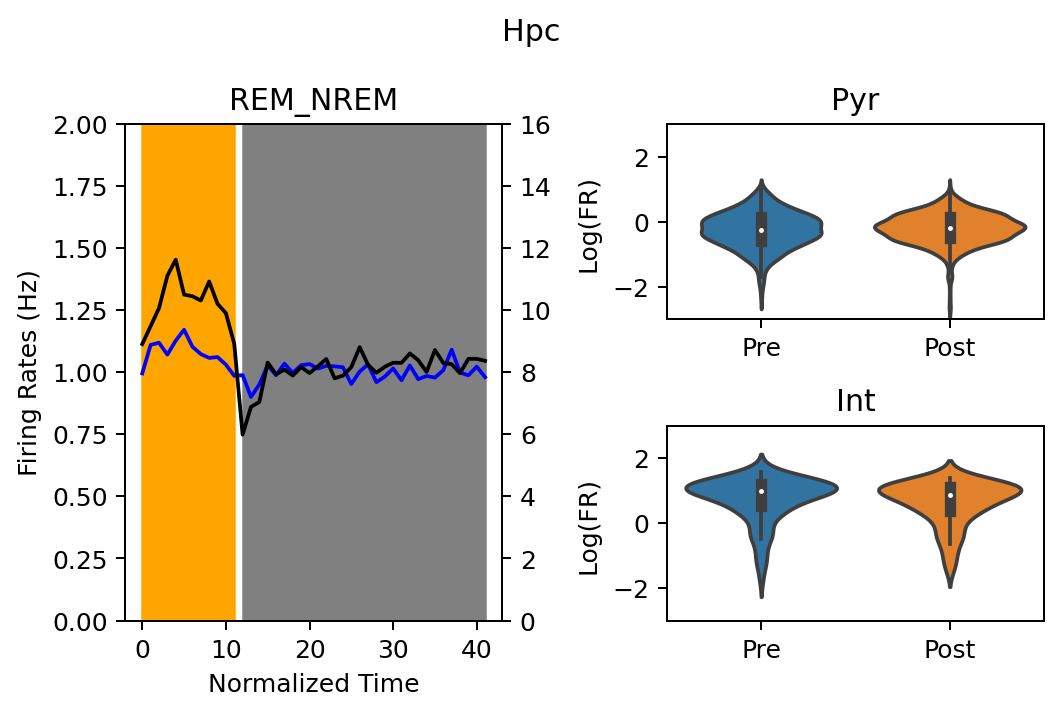

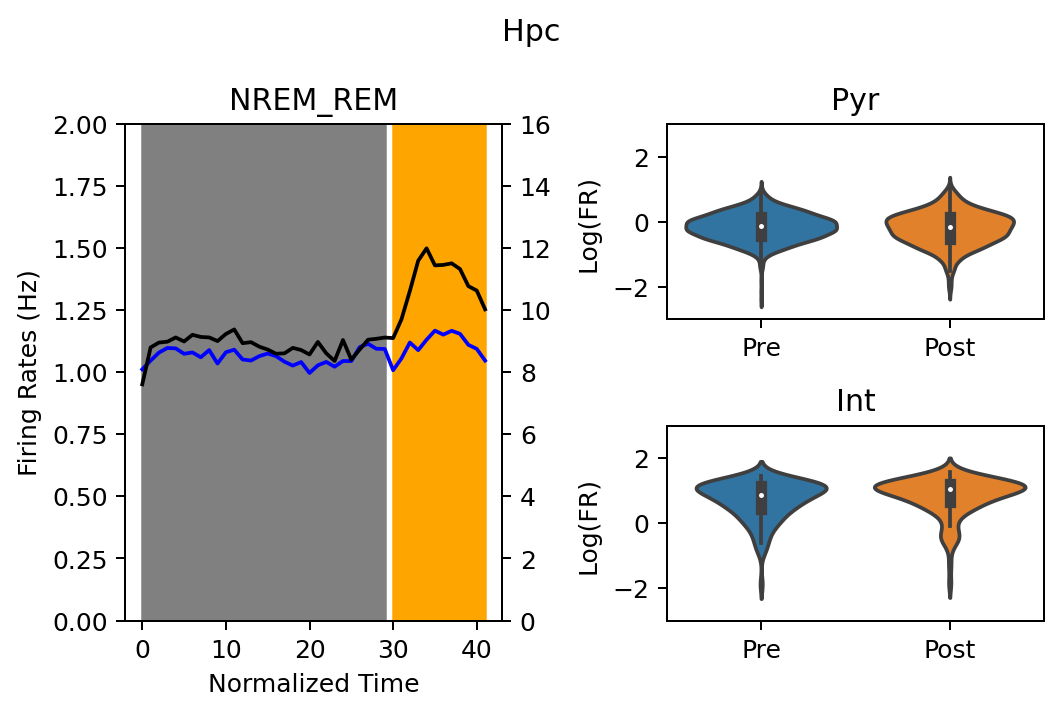

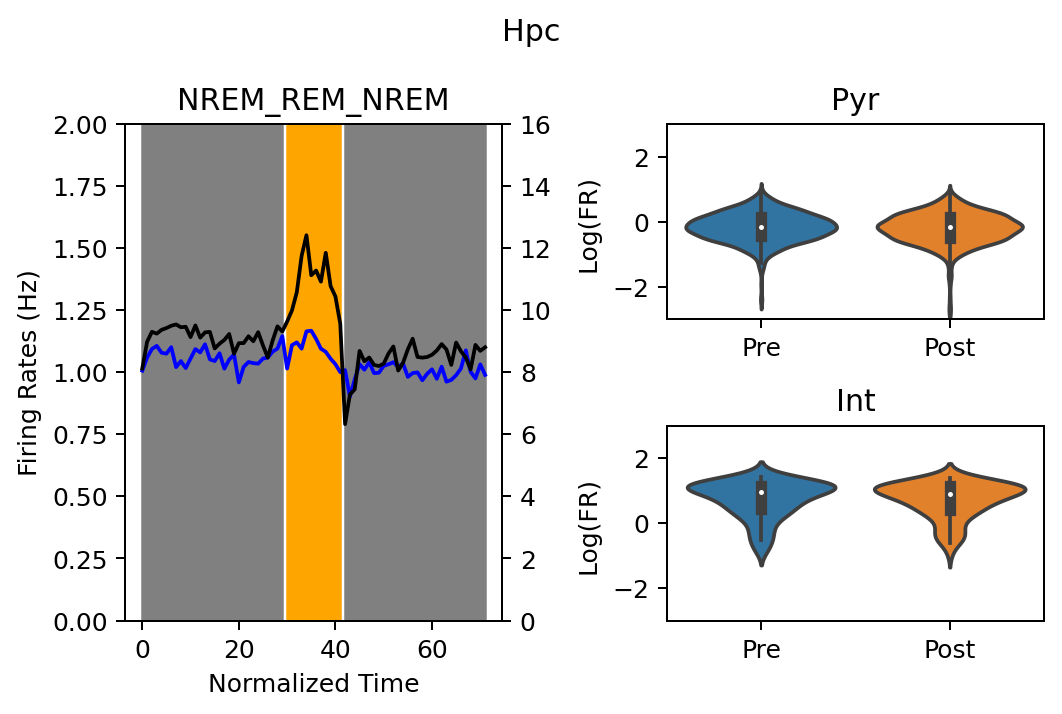

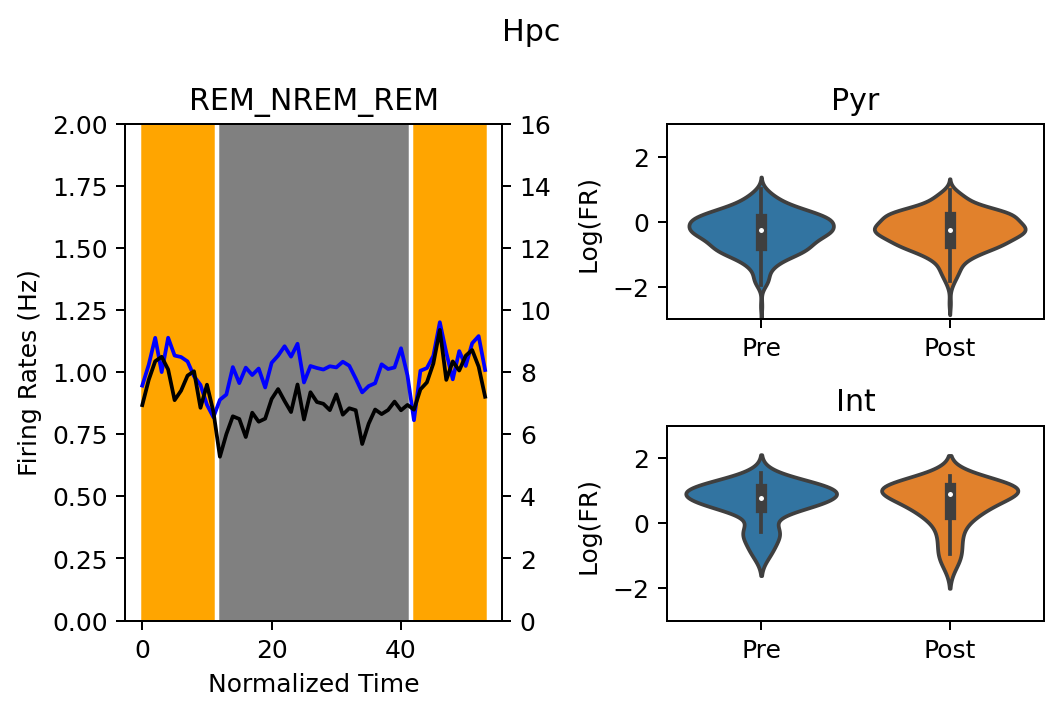

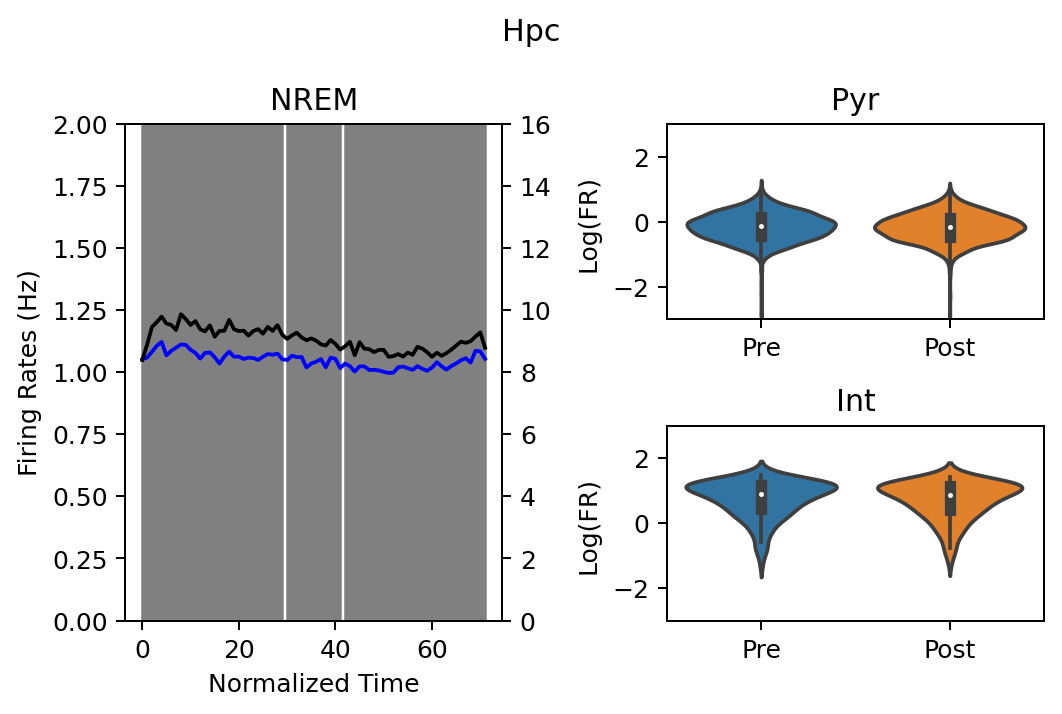

In [70]:
stru = 'Hpc'
norm = 'FR'
merged_data = {'REM_NREM':[m_REM_NREM,['orange','grey']],
               'NREM_REM':[m_NREM_REM,['grey','orange']],
               'NREM_REM_NREM':[m_NREM_REM_NREM,['grey','orange','grey']],
               'REM_NREM_REM':[m_REM_NREM_REM,['orange','grey','orange']],
               'NREM_Control':[m_NREM,['grey','grey','grey']]}


for name,data in merged_data.items():
    save_directory = '/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/Transitions/'
    save_path = os.path.join(save_directory,f'{norm}/{stru}/')
    save_name = f'{name}.svg'
    make_figure(data[0],stru,norm,ylimL=yLimPyr,ylimR=yLimInt,ylim_violin=ylim_violin,intervals_colors = data[1])
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    plt.savefig(os.path.join(save_path,save_name))
    



In [51]:
print('                   Pyramidaux' , '              Interneurons')
print('NREM_REM_NREM',statistics(m_NREM_REM_NREM,'BLA',[0,29],[42,71]))
print('NREM',statistics(m_NREM,'BLA',[0,29],[42,71]))
print('REM_NREM_REM',statistics(m_REM_NREM_REM,'BLA',[0,11],[42,54]))

                   Pyramidaux               Interneurons
NREM_REM_NREM (2.085354728776074e-22, 1.9055085023107943e-09)
NREM (1.0238766150151973e-12, 3.6594455439511954e-17)
REM_NREM_REM (0.12955584965911915, 0.25897202901398186)
